In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm

In [46]:
# Step 1: Define a grid on the sphere
n_theta, n_phi = 100, 200
theta = np.linspace(0, np.pi, n_theta)       # colatitude [0, pi]
phi = np.linspace(0, 2 * np.pi, n_phi)       # longitude [0, 2pi]
theta, phi = np.meshgrid(theta, phi)

In [47]:
f = (np.sin(theta) ** 2) * np.cos(2 * phi)

In [48]:
def sph_harm_decompose(f, theta, phi, lmax):
    coeffs = {}
    dtheta = theta[0, 1] - theta[0, 0]
    dphi = phi[1, 0] - phi[0, 0]
    sin_theta = np.sin(theta)

    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            Ylm = sph_harm(m, l, phi, theta)
            integrand = f * np.conj(Ylm) * sin_theta
            integral = np.sum(integrand) * dtheta * dphi
            coeffs[(l, m)] = integral
    return coeffs

In [51]:
# Decompose up to l = 5
lmax = 8
coeffs2 = sph_harm_decompose(f, theta, phi, lmax)
print (list(coeffs2.values()))

[(0.011875737845077613+0j), (0.012851346400149056+2.847683147868619e-17j), (-2.002277213345123e-18+0j), (-0.012851346400149056+2.847683147868619e-17j), (1.3074264938717848+2.1357623609014643e-17j), (6.8967326237443115e-18+8.342821722271345e-19j), (-0.005310991016652639+0j), (1.1123762296361793e-18+2.8921781970540663e-18j), (1.307426493871785-2.847683147868619e-17j), (0.012932895998635225-5.695366295737238e-17j), (-4.421695512803813e-18+1.1123762296361793e-19j), (-0.002003555632837858+2.6697029511268304e-18j), (-2.8365593855722572e-18+0j), (0.0020035556328378613-6.229306885962604e-18j), (-3.262043293408096e-17+6.674257377817076e-19j), (-0.012932895998635197-2.847683147868619e-17j), (0.012774799304485619+8.543049443605857e-17j), (8.342821722271345e-19+2.6697029511268304e-18j), (-5.172573247631083e-11-2.6140841396450213e-18j), (-9.80281552366883e-19+0j), (4.527895278097294e-10+0j), (7.717110093100994e-19+9.594244980612045e-19j), (-5.1725728902802196e-11+8.620915779680389e-19j), (6.6742573

In [28]:
print (len(coeffs))
a = []
for i in range(lmax+1):
    a.extend([_ for m in range(-i, i+1)])
print (len(a))

81
81


In [16]:
# Step 4: Reconstruct function from spherical harmonics
f_reconstructed = np.zeros_like(f, dtype=np.complex128)
for (l, m), c in coeffs.items():
    Ylm = sph_harm(m, l, phi, theta)
    f_reconstructed += c * Ylm

In [17]:
# Step 5: Plot original and reconstructed function
def plot_on_sphere(data, title):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, projection='mollweide')
    ax.pcolormesh(phi - np.pi, np.pi/2 - theta, data.real, cmap='viridis')
    ax.set_title(title)
    plt.show()

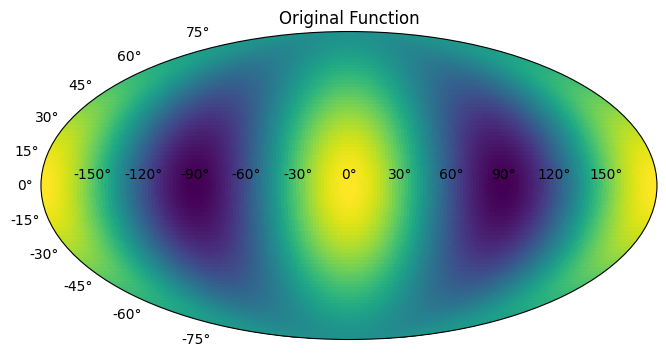

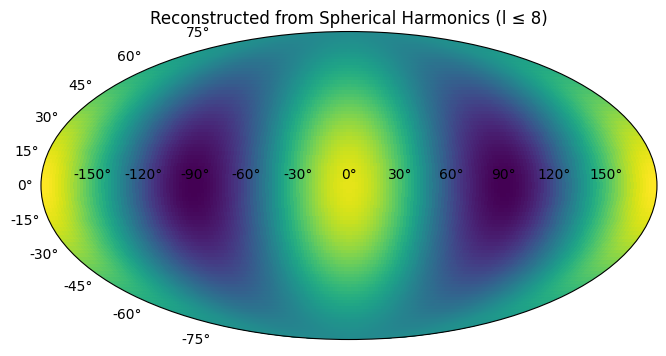

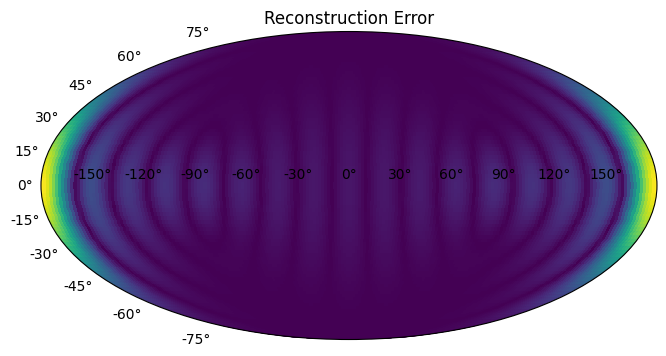

In [19]:
plot_on_sphere(f, "Original Function")
plot_on_sphere(f_reconstructed.real, "Reconstructed from Spherical Harmonics (l ≤ 8)")
plot_on_sphere(np.abs(f - f_reconstructed.real), "Reconstruction Error")

In [52]:
import e3nn
from e3nn.o3 import spherical_harmonics
import torch

def random_points_on_sphere(N):
    theta = 2 * torch.pi * torch.rand(N)  # uniform in [0, 2pi)
    z = 2 * torch.rand(N) - 1             # uniform in [-1, 1]
    r = torch.sqrt(1 - z**2)              # radius in xy-plane
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.stack([x, y, z], dim=1)  # shape: [N, 3]

In [53]:
coords = random_points_on_sphere(10)
sph = spherical_harmonics(l=range(lmax+1), x=coords, normalize=True, normalization="integral")

In [58]:
n_theta, n_phi = 100, 200
theta = torch.linspace(0, np.pi, n_theta)
phi = torch.linspace(0, 2 * np.pi, n_phi)
theta, phi = torch.meshgrid(theta, phi, indexing="ij")
f = (torch.sin(theta)**2 * torch.cos(2 * phi)).reshape(-1)

In [59]:
x = torch.sin(theta) * torch.cos(phi)
y = torch.sin(theta) * torch.sin(phi)
z = torch.cos(theta)
xyz = torch.stack([x, y, z], dim=-1).reshape(-1, 3)  # shape: [N, 3]

# Step 2: Define a toy function on the sphere: f(θ, φ) = sin^2(θ) * cos(2φ)
f = (torch.sin(theta)**2 * torch.cos(2 * phi)).reshape(-1)

In [ ]:
lmax = 8
L = [l for l in range(lmax + 1)]  # degrees
Y = spherical_harmonics(L, xyz, normalize=True, normalization='component')  # shape [N, num_sh]

coeffs, _, _, _ = torch.linalg.lstsq(f[:, None], Y)  # shape [num_sh, 1]

torch.Size([1, 81])
tensor([[ 1.3267e-02,  1.9505e-02,  6.3732e-08,  3.9032e-09,  1.0060e-09,
          1.3042e-07, -1.6752e+00, -3.8135e-09, -9.7146e-01, -4.7111e-03,
          2.2526e-09, -1.8246e-02, -2.2630e-07, -1.1515e-07, -1.8821e-07,
         -7.0258e-08,  5.3072e-09,  1.6541e-07, -6.5607e-09,  4.0002e-07,
          1.6962e-01,  2.2608e-09, -1.2724e-01,  1.2493e-10, -1.8304e-01,
         -7.4871e-04,  1.4426e-09,  3.9060e-03, -8.9837e-10,  1.8082e-02,
          1.2807e-07, -3.5129e-08,  6.4129e-08,  1.3661e-08, -3.1718e-08,
          3.1226e-08, -1.1344e-08,  1.1917e-07, -3.7630e-09,  2.5353e-07,
         -2.8005e-09,  2.7079e-07, -6.0702e-02,  5.3419e-09,  4.2843e-02,
          2.0139e-09, -1.7293e-02, -2.0381e-09, -7.0246e-02, -2.6890e-04,
         -3.2519e-09,  5.9174e-04, -4.0789e-09, -3.7478e-03, -9.8661e-11,
         -1.8031e-02, -1.9638e-07,  1.5808e-07, -1.5564e-07, -6.2452e-08,
         -2.7750e-08,  2.3419e-08, -8.5612e-09,  9.3678e-08,  4.5872e-09,
          8.5334e-

In [62]:
f_reconstructed = (Y @ coeffs.T).reshape(n_theta, n_phi)

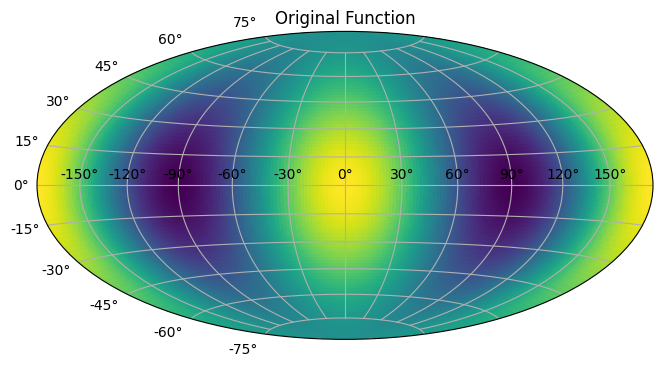

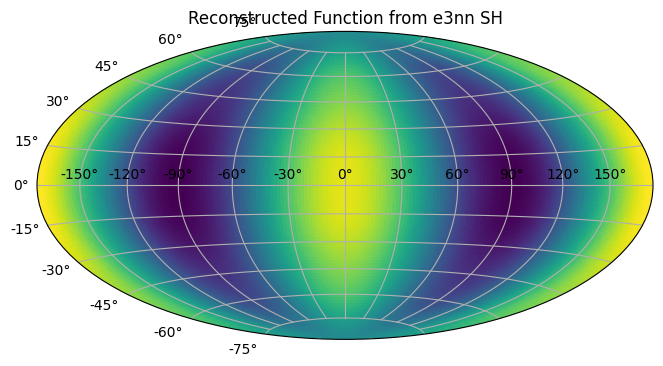

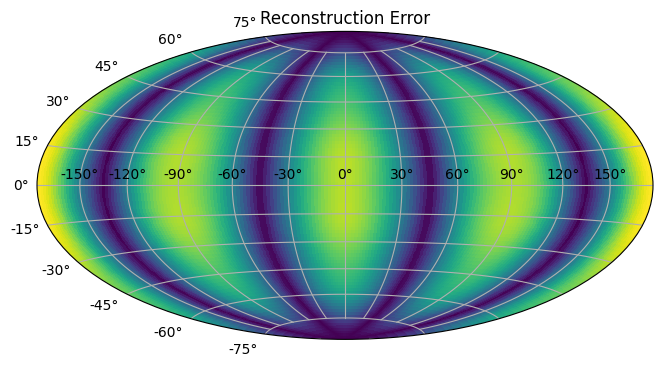

In [64]:
def plot_mollweide(data, title):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, projection='hammer')
    phi_plot = phi.numpy() - np.pi
    theta_plot = np.pi / 2 - theta.numpy()
    ax.pcolormesh(phi_plot, theta_plot, data.numpy(), shading='auto', cmap='viridis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

plot_mollweide(f.reshape(n_theta, n_phi), "Original Function")
plot_mollweide(f_reconstructed, "Reconstructed Function from e3nn SH")
plot_mollweide(torch.abs(f.reshape(n_theta, n_phi) - f_reconstructed), "Reconstruction Error")
